In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline
from pprint import pprint

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split, learning_curve, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer

from sklearn.preprocessing import RobustScaler, MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Alternative data
#data = pd.read_csv('./exported_features/all_features.csv')
#features_df = data.drop('id', axis=1).drop('revenue', axis=1)
#target = data.revenue
#X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.2, random_state=42)

In [12]:
flo_columns = [
    'id',
    'Age',
    'hasStar',
    'NumStar',
    'hashomepage',
    'isinCollection',
    'Action',
    'Family',
    'Adventure',
    'History',
    'Drama',
    'Science Fiction',
    'Romance',
    'Fantasy',
    'Horror',
    'Animation',
    'numberGenres']

data = pd.read_csv('../data/train.csv')
flo_features = pd.read_csv('./exported_features/all_features.csv')[flo_columns]
marcel_keywords = pd.read_csv('../data/marcel_features.csv').drop('Unnamed: 0', axis=1)

data['popularity'] = np.log1p(data.popularity)
data['budget'] = np.log1p(data.budget)
data = data.merge(marcel_keywords, on=['id'], how='left').merge(flo_features, on=['id'], how='left')
data.runtime = data.runtime.fillna(np.mean(data.runtime))

features = list(flo_features.columns) + ['popularity', 'budget', 'has_top_keyword', 'runtime']
features.remove('id')

features_df = data[features]
target = data.revenue

X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.2, random_state=42)

In [4]:
# Scaling features
scaler = RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

----

In [5]:
# Define own scoring function
# because target is actually log(target)
def my_score(y_true, y_pred):
    '''
    Compute the RMSLE on the actual target values, not the log target
    '''
    if any(np.expm1(y_pred) < 0):
        return np.Infinity
    else:
        return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))
scoring_fnc = make_scorer(my_score)


# Define own scoring function
# because target is actually log(target)
# returns -error, because grid search maximizes the eval metric
def my_score_neg(y_true, y_pred):
    '''
    Compute the RMSLE on the actual target values, not the log target
    '''
    if any(np.expm1(y_pred) < 0):
        return -1 * np.Infinity
    else:
        return -1 * np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))
scoring_fnc_neg = make_scorer(my_score_neg)


def train_and_eval(model, X_train, y_train, scoring):
    cv_results = cross_validate(model, 
                                X_train, 
                                np.log1p(y_train), 
                                cv=10, 
                                scoring=scoring, 
                                return_train_score=True)
    
    mean_train = np.mean(cv_results['train_score'])
    mean_cv = np.mean(cv_results['test_score'])
    std_train = np.std(cv_results['train_score'])
    std_cv = np.std(cv_results['test_score'])

    result_summary = {
        'model': model,
        'mean_train_score': mean_train,
        'mean_cv_score': mean_cv,
        'std_train_score': std_train,
        'std_cv_score': std_cv
    }
    
    return result_summary


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=(10,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring_fnc)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### Linear Regression

{'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 'mean_train_score': 2.275101612916185,
 'mean_cv_score': 2.2827795161358684,
 'std_train_score': 0.026096245048909065,
 'std_cv_score': 0.22792107768268943}

<module 'matplotlib.pyplot' from 'C:\\Users\\Cruzz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

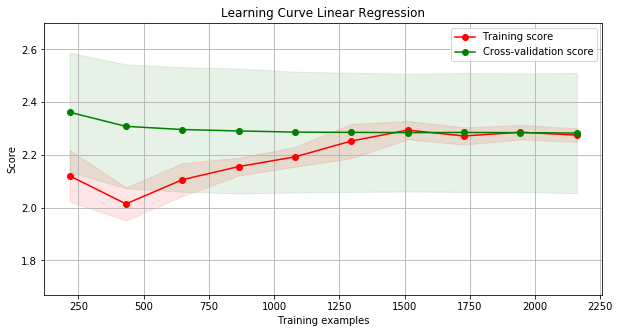

In [6]:
reg = LinearRegression()
display(train_and_eval(reg, X_train, y_train, scoring_fnc))
plot_learning_curve(reg, 'Learning Curve Linear Regression', X_train, np.log1p(y_train), cv=10, train_sizes=np.linspace(.1, 1.0, 10), ylim=(1.67, 2.7))

### Lasso

{'model': Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False),
 'mean_train_score': 2.277497528132305,
 'mean_cv_score': 2.28227407420594,
 'std_train_score': 0.026094895567196876,
 'std_cv_score': 0.2300572437219708}

<module 'matplotlib.pyplot' from 'C:\\Users\\Cruzz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

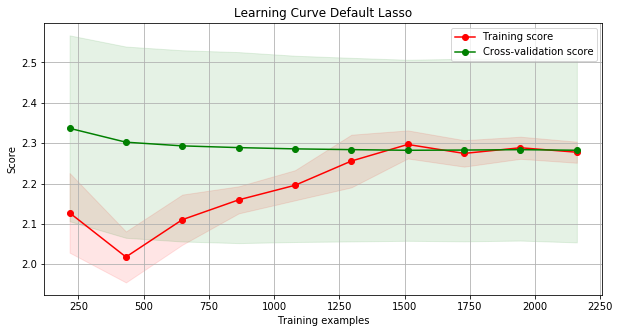

In [7]:
lasso = Lasso(alpha=0.01)
display(train_and_eval(lasso, X_train_scaled, y_train, scoring_fnc))
plot_learning_curve(lasso, 'Learning Curve Default Lasso', X_train, np.log1p(y_train), cv=10, train_sizes=np.linspace(.1, 1.0, 10))

### Ridge

{'model': Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 'mean_train_score': 2.275101613101146,
 'mean_cv_score': 2.28277877102206,
 'std_train_score': 0.02609624505118275,
 'std_cv_score': 0.22792232132577367}

<module 'matplotlib.pyplot' from 'C:\\Users\\Cruzz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

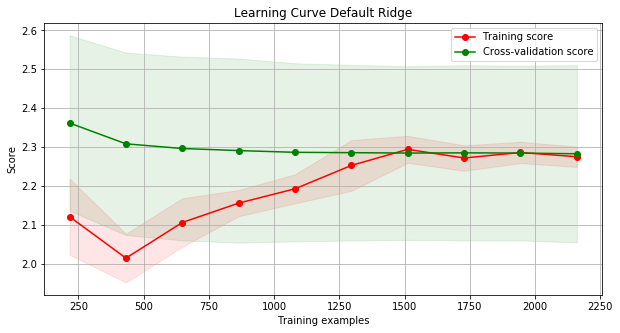

In [8]:
ridge = Ridge(alpha=0.01)
display(train_and_eval(ridge, X_train_scaled, y_train, scoring_fnc))
plot_learning_curve(ridge, 'Learning Curve Default Ridge', X_train, np.log1p(y_train), cv=10, train_sizes=np.linspace(.1, 1.0, 10))

### SVM

{'model': SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
   gamma='auto_deprecated', kernel='rbf', max_iter=10000, shrinking=True,
   tol=0.001, verbose=False),
 'mean_train_score': 2.256559295073478,
 'mean_cv_score': 2.278979679002298,
 'std_train_score': 0.029506651403248985,
 'std_cv_score': 0.26687108281501004}

<module 'matplotlib.pyplot' from 'C:\\Users\\Cruzz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

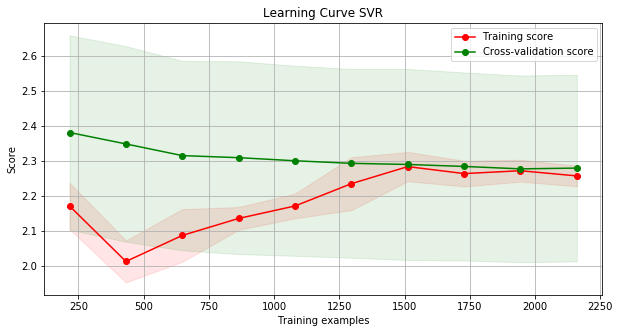

In [11]:
svr = SVR(kernel='rbf', max_iter=10000)
display(train_and_eval(svr, X_train_scaled, y_train, scoring_fnc))
plot_learning_curve(svr, 'Learning Curve SVR', X_train_scaled, np.log1p(y_train), cv=10, train_sizes=np.linspace(.1, 1.0, 10))

### Random Forest

{'model': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0, warm_start=False),
 'mean_train_score': 0.8689588306830194,
 'mean_cv_score': 2.0603795954401054,
 'std_train_score': 0.028335831145864274,
 'std_cv_score': 0.20811434740873225}

<module 'matplotlib.pyplot' from 'C:\\Users\\Cruzz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

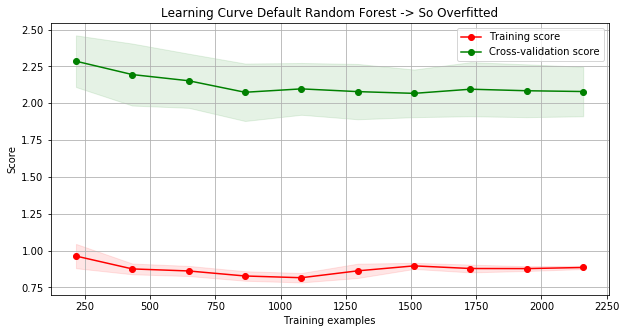

In [15]:
rf_reg = RandomForestRegressor()
display(train_and_eval(rf_reg, X_train, y_train, scoring_fnc))
plot_learning_curve(rf_reg, 'Learning Curve Default Random Forest -> So Overfitted', X_train, np.log1p(y_train), cv=10, train_sizes=np.linspace(.1, 1.0, 10))

#### GridSearch

In [16]:
# Number of trees
n_estimators = [10, 20, 30, 50, 100, 200]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [2, 3, 5, 8]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

pprint(param_grid)

rf = RandomForestRegressor()
rf_grid = GridSearchCV(rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2, scoring=scoring_fnc_neg)
rf_grid.fit(X_train, np.log1p(y_train))

{'max_depth': [2, 3, 5, 8, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 10],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 20, 30, 50, 100, 200]}
Fitting 10 folds for each of 720 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 611 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 2069 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3084 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3529 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 4662 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 5475 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 6335 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed:  6.7min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30, 50, 100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 3, 5, 8, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(my_score_neg), verbose=2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
-1.9415584130877046


{'model': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0, warm_start=False),
 'mean_train_score': 1.3391927092311877,
 'mean_cv_score': 1.9448062059016942,
 'std_train_score': 0.01540568681565355,
 'std_cv_score': 0.18096120730094473}

<module 'matplotlib.pyplot' from 'C:\\Users\\Cruzz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

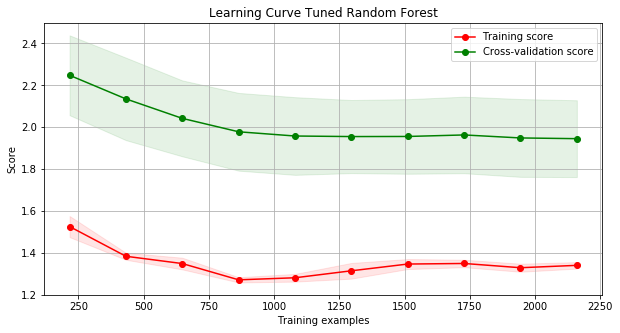

In [17]:
pprint(rf_grid.best_estimator_)
print(rf_grid.best_score_)
rf_reg = rf_grid.best_estimator_
display(train_and_eval(rf_reg, X_train, y_train, scoring_fnc))
plot_learning_curve(rf_reg, 'Learning Curve Tuned Random Forest', X_train, np.log1p(y_train), cv=10, train_sizes=np.linspace(.1, 1.0, 10))

### Gradient Boosting

{'model': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, n_iter_no_change=None, presort='auto',
              random_state=None, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False),
 'mean_train_score': 1.6647091126102762,
 'mean_cv_score': 1.9383099744742331,
 'std_train_score': 0.02293795405251852,
 'std_cv_score': 0.17062227964082435}

C:\Users\Cruzz\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


<module 'matplotlib.pyplot' from 'C:\\Users\\Cruzz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

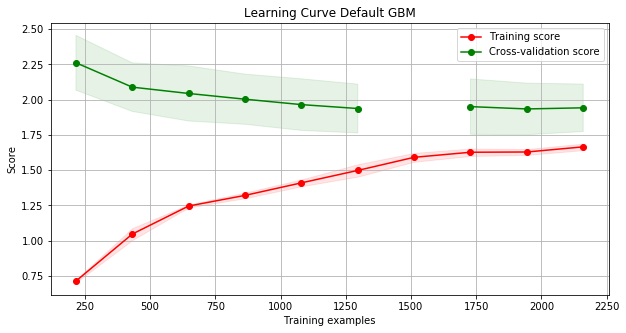

In [12]:
gb = GradientBoostingRegressor()
display(train_and_eval(gb, X_train, y_train, scoring_fnc))
plot_learning_curve(gb, 'Learning Curve Default GBM', X_train, np.log1p(y_train), cv=10, train_sizes=np.linspace(.1, 1.0, 10))

#### Grid Search

In [18]:
# Learning rate
learning_rate = [0.01, 0.1, 0.15, 0.2]

# Number of trees
n_estimators = [100, 200, 300, 400, 500]

# Max Depth
max_depth = [1, 2, 3, 5]

# Create the random grid
param_grid = {'learning_rate': learning_rate,
                'n_estimators': n_estimators, 
                'max_depth': max_depth}

pprint(param_grid)

gb = GradientBoostingRegressor()
gb_grid = GridSearchCV(gb, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2, scoring=scoring_fnc_neg)
gb_grid.fit(X_train, np.log1p(y_train))

{'learning_rate': [0.01, 0.1, 0.15, 0.2],
 'max_depth': [1, 2, 3, 5],
 'n_estimators': [100, 200, 300, 400, 500]}
Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 234 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 437 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.9min finished
C:\Users\Cruzz\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:791: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.1, 0.15, 0.2], 'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [1, 2, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(my_score_neg), verbose=2)

-1.9254259164421201


{'model': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='ls', max_depth=5, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=400, n_iter_no_change=None, presort='auto',
              random_state=None, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False),
 'mean_train_score': 1.5089249091636774,
 'mean_cv_score': 1.9256132301506272,
 'std_train_score': 0.02425773952231327,
 'std_cv_score': 0.1713332170199833}

<module 'matplotlib.pyplot' from 'C:\\Users\\Cruzz\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

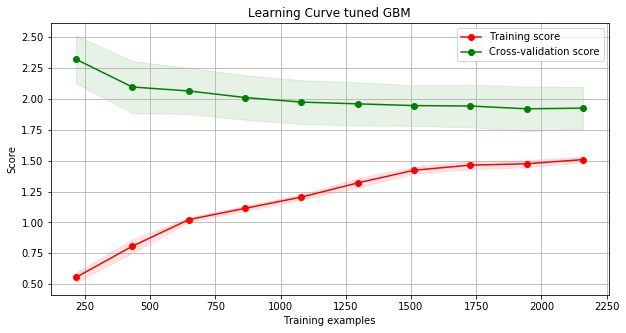

In [19]:
print(gb_grid.best_score_)
display(train_and_eval(gb_grid.best_estimator_, X_train, y_train, scoring_fnc))
plot_learning_curve(gb_grid.best_estimator_, 'Learning Curve tuned GBM', X_train, np.log1p(y_train), cv=10, train_sizes=np.linspace(.1, 1.0, 10))